In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data as data

In [2]:
# 定义dataset
class my_Dataset(data.Dataset):#继承？
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [3]:
class TrafficDataset:
    def __init__(self, sensor_num=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load('./traffic-flow/traffic.npz')['data']
        self.sensor_num = sensor_num
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=12,label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * train_por)
        len_val = int(self.data.shape[0] * val_por)
        len_test = int(self.data.shape[0] * test_por)
        train_seqs = self.data[:len_train]
        val_seqs = self.data[len_train:len_val+len_train]
        test_seqs = self.data[len_train+len_val:len_val+len_train+len_test]

        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            train_y.append(train_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(val_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            val_y.append(val_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            test_y.append(test_seqs[i+window_size, self.sensor_num, self.target].squeeze())
        
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

In [4]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set()
batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

<ipython-input-3-72cc8f8dabf6>:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))


In [5]:
from utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

In [12]:
lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=1,batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),nn.LeakyReLU()).to(device)
optimizer = torch.optim.Adam(list(lstm.parameters()) + list(out_linear.parameters()), lr)

In [14]:
train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0499, train rmse 244.8559, val loss 0.0181, val rmse 139.970546, time use 0.425s
*** epoch2, train loss 0.0160, train rmse 144.3124, val loss 0.0110, val rmse 108.102995, time use 0.407s
*** epoch3, train loss 0.0067, train rmse 92.2684, val loss 0.0043, val rmse 66.328987, time use 0.408s
*** epoch4, train loss 0.0040, train rmse 71.9266, val loss 0.0040, val rmse 64.178257, time use 0.383s
*** epoch5, train loss 0.0039, train rmse 70.3821, val loss 0.0038, val rmse 62.024550, time use 0.385s
*** epoch6, train loss 0.0037, train rmse 69.1916, val loss 0.0037, val rmse 61.724607, time use 0.373s
*** epoch7, train loss 0.0036, train rmse 67.6269, val loss 0.0036, val rmse 59.914477, time use 0.388s
*** epoch8, train loss 0.0035, train rmse 66.4365, val loss 0.0034, val rmse 57.793457, time use 0.407s
*** epoch9, train loss 0.0033, train rmse 65.1991, val loss 0.0033, val rmse 57.090895, time use 0.395s
*** epoch10, train loss 0.0032, train rmse 63.9724, val loss

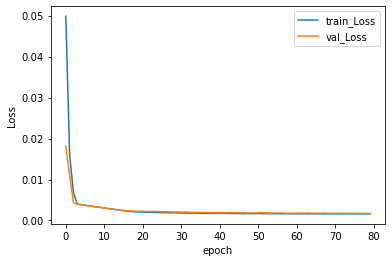

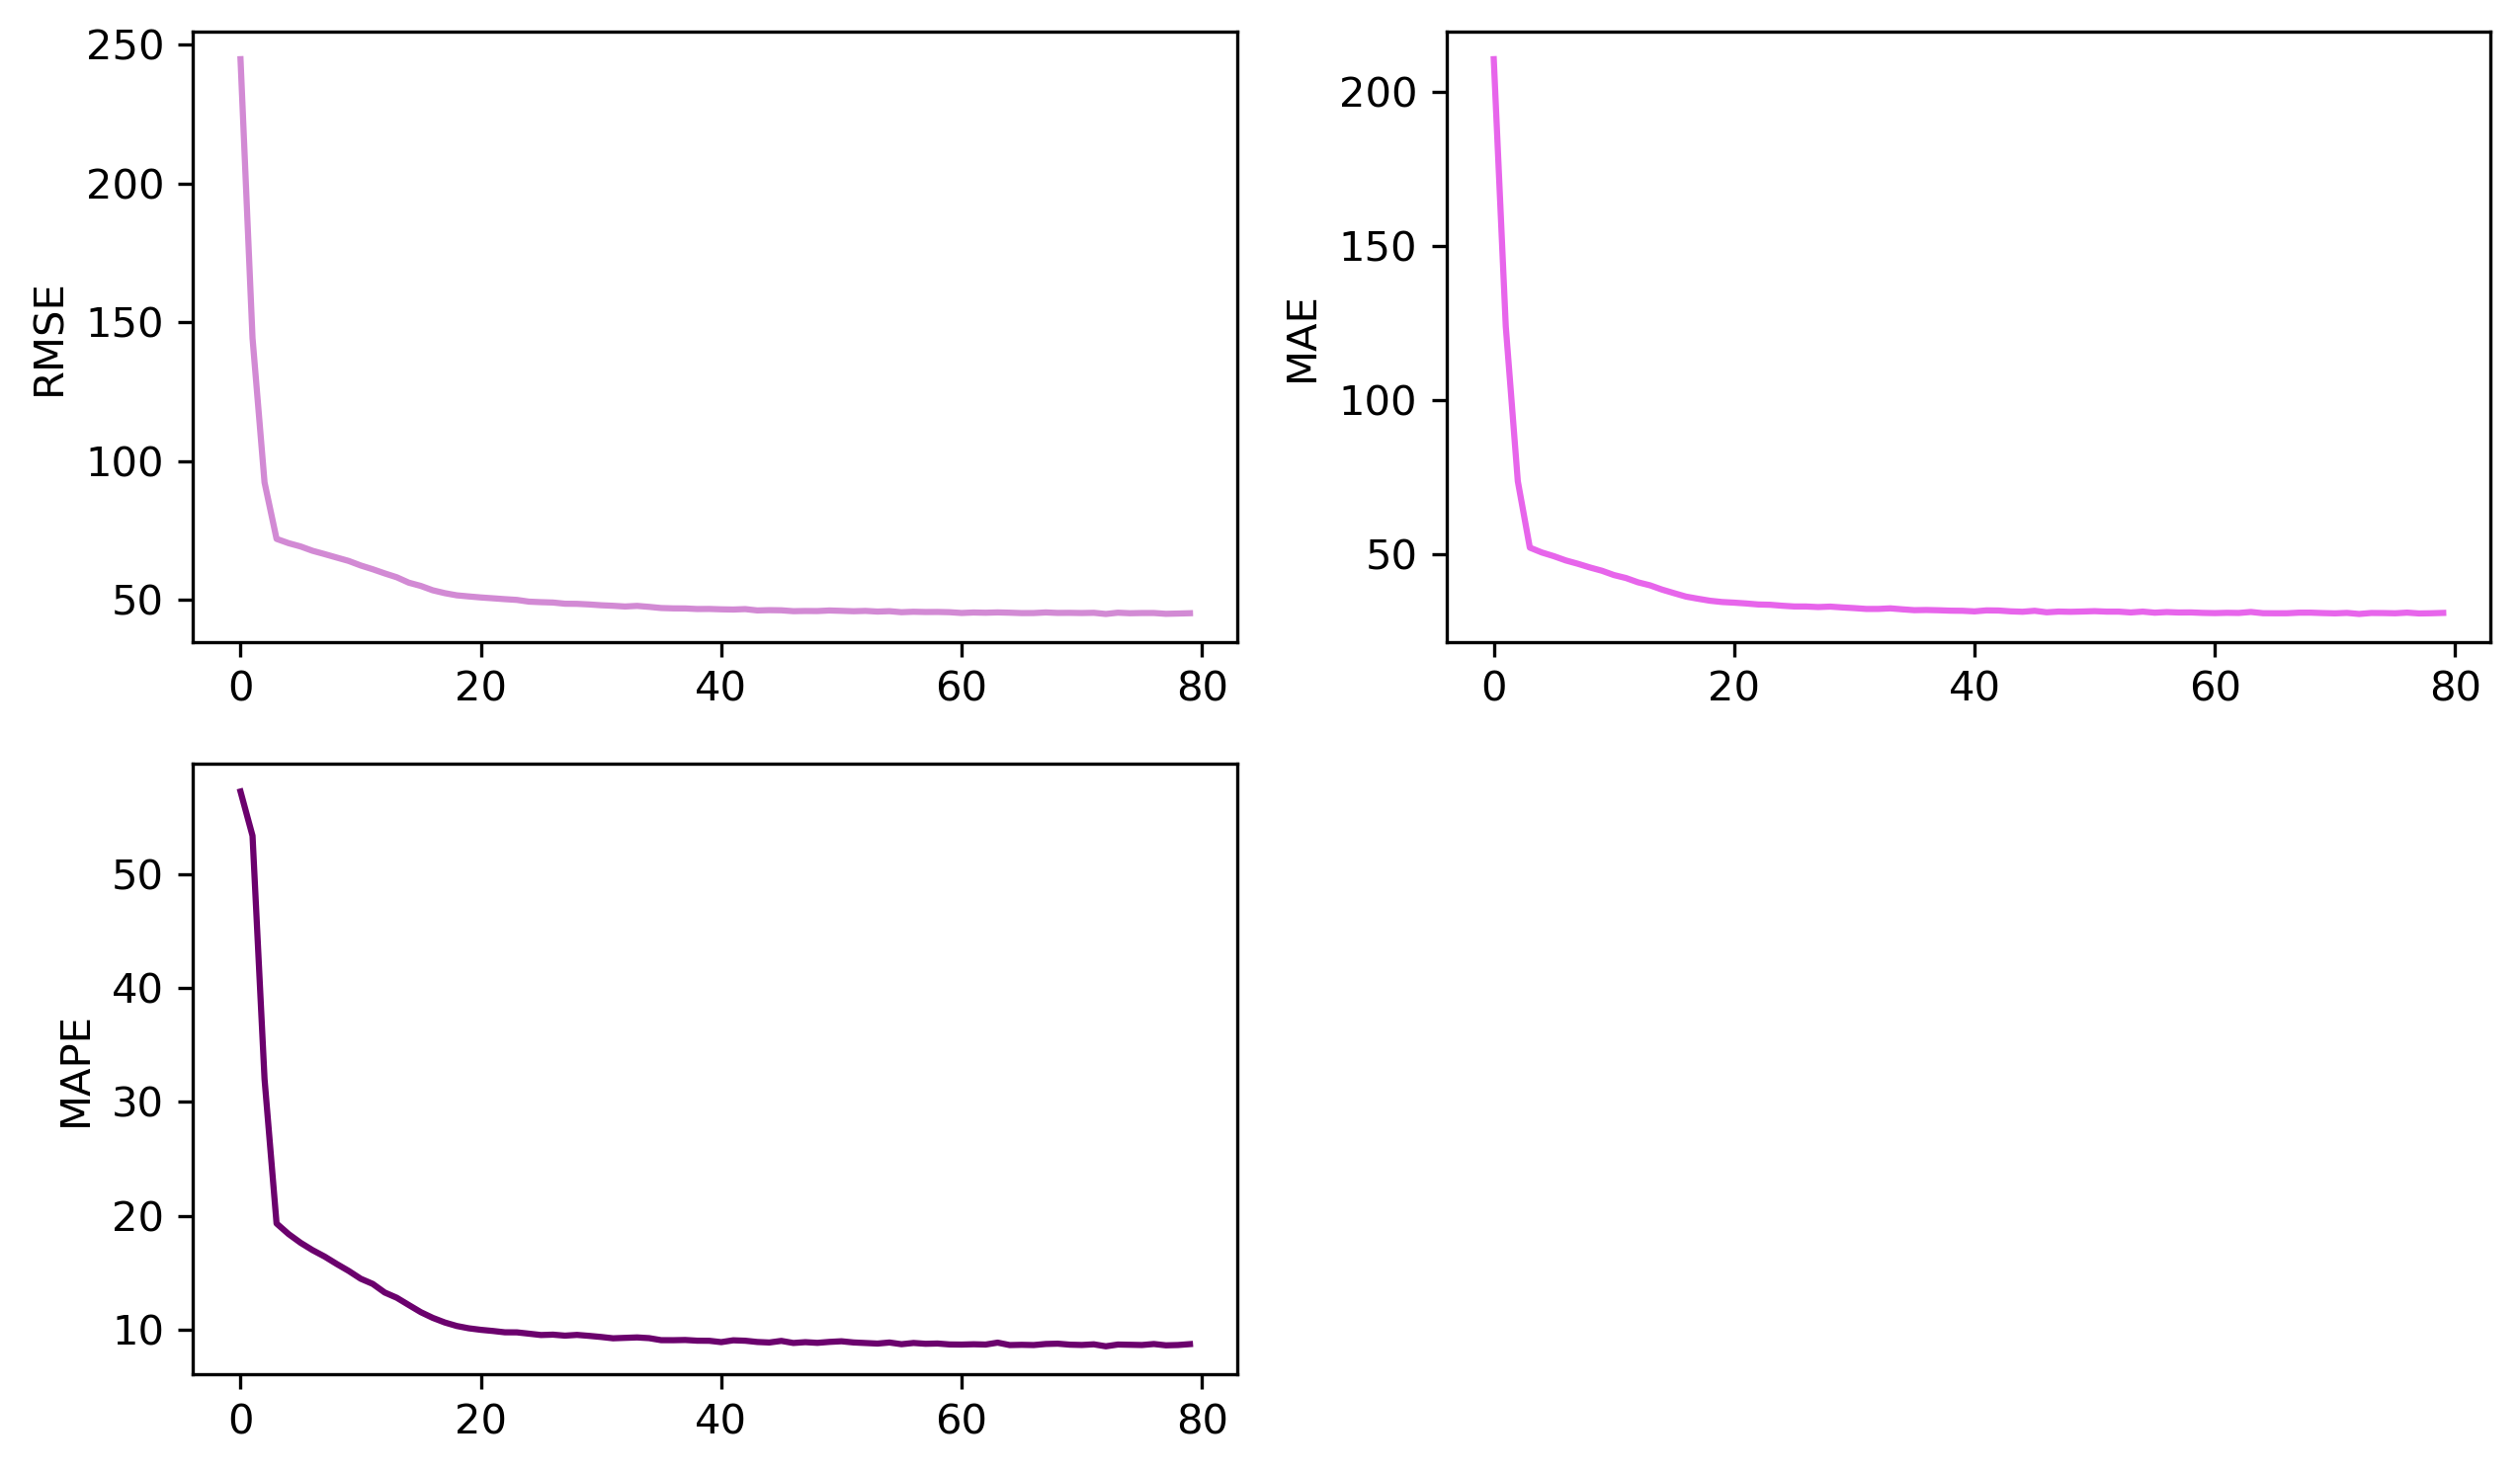

In [15]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)